In [323]:
import math
import re
import string
import os

import nltk
import pandas as pd
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

data = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv', encoding='ISO-8859-1', sep=',')

head = data.head()
info = data.info()
describe = data.describe()
data.shape
#head, info, describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  object 
 1   dateAdded             10000 non-null  object 
 2   dateUpdated           10000 non-null  object 
 3   address               10000 non-null  object 
 4   categories            10000 non-null  object 
 5   primaryCategories     10000 non-null  object 
 6   city                  10000 non-null  object 
 7   country               10000 non-null  object 
 8   keys                  10000 non-null  object 
 9   latitude              10000 non-null  float64
 10  longitude             10000 non-null  float64
 11  name                  10000 non-null  object 
 12  postalCode            10000 non-null  object 
 13  province              10000 non-null  object 
 14  reviews.date          10000 non-null  object 
 15  reviews.dateAdded   

(10000, 26)

In [324]:
data = data[['reviews.rating', 'reviews.text', 'reviews.title']]
data['reviews.text'] = data['reviews.title'] + " " + data['reviews.text']
data.shape

(10000, 3)

In [325]:
data = data.drop_duplicates()
data = data.dropna()
data.shape

(9786, 3)

In [326]:
import matplotlib.pyplot as plt

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"


data['lang'] = data['reviews.text'].apply(lambda x: detect_lang(x))
data = data.loc[data['lang'] == 'en']
data['lang'].value_counts()
data.shape

(9770, 4)

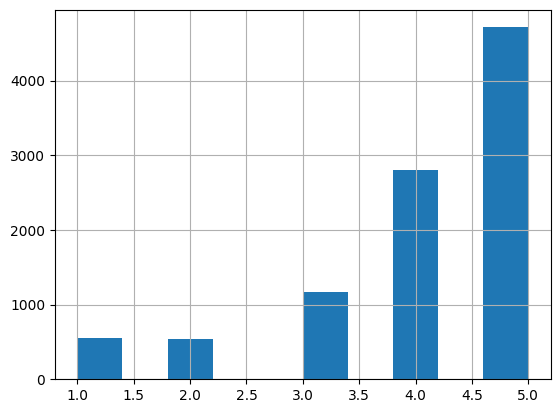

In [327]:
data['reviews.rating'].hist()
plt.show()

In [328]:
#afficher le nombre de commentaire avec une note 0
data.loc[data['reviews.rating'] == 1].shape

(555, 4)

In [329]:
#afficher le nombre de commentaire avec une note 5
data.loc[data['reviews.rating'] == 5].shape

(4714, 4)

In [330]:
data['reviews.rating'] = data['reviews.rating'].apply(lambda x: x - 5 if x > 5 else x)
data['reviews.rating'] = data['reviews.rating'].apply(lambda x: math.floor(x))
data.loc[data['reviews.rating'] == 1].shape, data.loc[data['reviews.rating'] == 5].shape

((555, 4), (4714, 4))

In [331]:
nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = nltk.corpus.stopwords.words('english')
#ps = nltk.PorterStemmer()
lem = nltk.WordNetLemmatizer()


def clean_text(text):
    result = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', result)
    text = [lem.lemmatize(word) for word in tokens if word not in en_stopwords]
    return text

<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
/var/folders/l1/c9cqs1hx4vx2w36p7pg1dhq80000gn/T/ipykernel_6773/3100574705.py:10: SyntaxWarning: invalid escape sequence '\W'
  tokens = re.split('\W+', result)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pieroneri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pieroneri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [332]:
positive_com = data[data['reviews.rating'] == 5]['reviews.text']
negative_com = data[data['reviews.rating'] == 1]['reviews.text']
positive_com.head(), negative_com.head()

(3     Very good Not cheap but excellent location. Pr...
 8                   Location Location Location MoreMore
 10    Beautiful hotel This is a new Hampton Inn and ...
 12    Under construction and extremely accomodating ...
 14    Excellent hotel Great staff and rooms. Houseke...
 Name: reviews.text, dtype: object,
 6     Does not live up to its reputation We recently...
 7     worst customer service ever I reserved a room ...
 9     The worst place i've booked Hello, I have trav...
 26    Horrible, closet like rooms with no air condit...
 30    In the valet parking they stole in the car. Un...
 Name: reviews.text, dtype: object)

In [333]:
sample_positive_text = " ".join(text for text in positive_com.sample(frac=0.1, random_state=23))
sample_negative_text = " ".join(text for text in negative_com.sample(frac=0.1, random_state=23))


In [334]:
wordcloud_positive = WordCloud(width=1600, height=800, max_words=200, background_color="white").generate(sample_positive_text)
wordcloud_negative = WordCloud(width=1600, height=800, max_words=200, background_color="white").generate(sample_negative_text)
plt.figure(figsize=(15, 7.5))

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

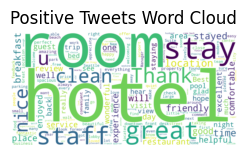

In [335]:
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

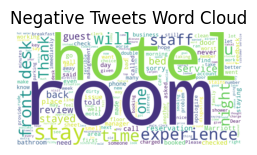

In [336]:
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis("off")

In [337]:
plt.show()

In [338]:
#get all 5 stars comments and 1 star comments
positive_sample = data[data['reviews.rating'] == 5].sample(frac=1, random_state=23)
negative_sample = data[data['reviews.rating'] == 1].sample(frac=1, random_state=23)

balanced_sample = pd.concat([positive_sample, negative_sample])
balanced_sample['reviews.rating'].value_counts()


reviews.rating
5    4714
1     555
Name: count, dtype: int64

In [339]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [340]:
vectorizer = TfidfVectorizer(max_features=10000, analyzer=clean_text)
X_train, X_val, y_train, y_val = train_test_split(data['reviews.text'], data['reviews.rating'], test_size=0.2, random_state=23)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

X_train_vectorized = X_train_vectorized.todense()
X_val_vectorized = X_val_vectorized.todense()

In [341]:
encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_val_encoded = to_categorical(encoder.transform(y_val))

In [370]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(X_train_vectorized.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')


In [360]:
X_train_vectorized.shape

(7816, 10000)

In [371]:

history = model.fit(X_train_vectorized, y_train_encoded, epochs=100, batch_size=16, 
                    validation_data=(X_val_vectorized, y_val_encoded), verbose=1)


Epoch 1/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4778 - loss: 1.4510 - val_accuracy: 0.4821 - val_loss: 1.2822
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.4754 - loss: 1.2909 - val_accuracy: 0.4821 - val_loss: 1.2719
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.4843 - loss: 1.2903 - val_accuracy: 0.4821 - val_loss: 1.2675
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.4751 - loss: 1.2897 - val_accuracy: 0.4821 - val_loss: 1.2634
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.4792 - loss: 1.2774 - val_accuracy: 0.4821 - val_loss: 1.2582
Epoch 6/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.4863 - loss: 1.2715 - val_accuracy: 0.4821 - val_loss: 1.2502
Epoch 7/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.4833 - loss: 1.2523 - val_accuracy: 0.4821 - val_loss: 1.2388
Epoch 8/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.4795 - loss: 1.2

In [373]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

/Users/timothee/CODE/COURS/MACHINE_LEARNING_IA/IA_ML/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


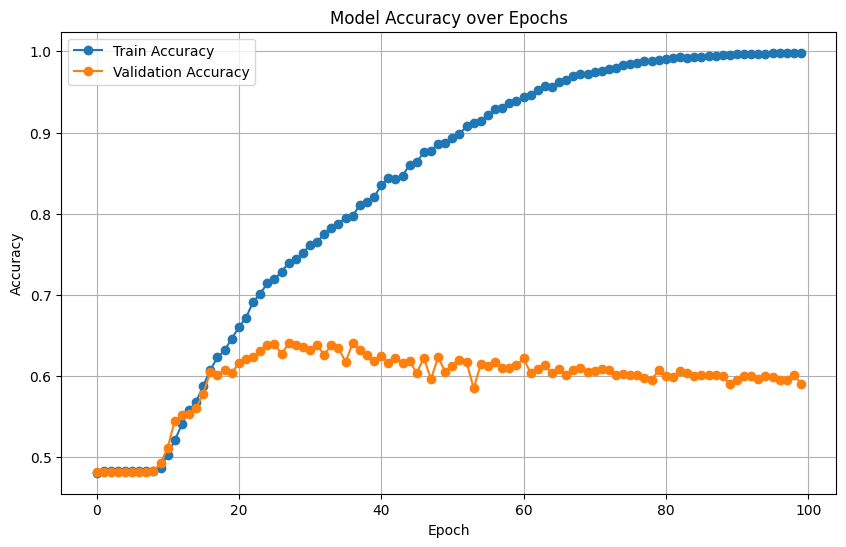

In [372]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()